![DSME-logo](./static/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
Reinforce Implementation

Notebook Authors: Ramil Sabirov

## Library Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os
#os.environ["WANDB_MODE"]="offline"

import time
import random

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from easydict import EasyDict as edict
from IPython.display import Video

import utils.helper_fns as hf

import gymnasium as gym
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical



os.environ['SDL_VIDEODRIVER'] = 'dummy'
os.environ['WANDB_NOTEBOOK_NAME'] = 'reinforce.ipynb'

plt.rcParams['figure.dpi'] = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

## Initializations

### Experiment Init

We primarily use dictionaries for initializing experiment parameters and training hyperparameters. We use the `EasyDict` (imported as `edict`) library, which allows us to access dict values as attributes while retaining the operations and properties of the original python `dict`! [[Github Link](https://github.com/makinacorpus/easydict)]

In this notebook we use a few `edicts` with `exp` being one of them. It is initialized in the following cell and has keys and values containing information about the experiment. Although the dict is initialized in this section, we keep adding new keys and values to the dict in the later sections as well.  

This notebook supports gymnasium environments with observation space of type `gym.spaces.Box` and action space of type `gym.spaces.Discrete`. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0

In [2]:
exp = edict()

exp.exp_name = 'REINFORCE'  # algorithm name, in this case it should be 'REINFORCE'
exp.env_id = 'CartPole-v1'  # name of the gymnasium environment to be used in this experiment. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0
exp.device = device.type  # save the device type used to load tensors and perform tensor operations

set_random_seed = True  # set random seed for reproducibility of python, numpy and torch
exp.seed = 1

# name of the project in Weights & Biases (wandb) to which logs are patched. (only if wandb logging is enabled)
# if the project does not exist in wandb, it will be created automatically
wandb_prj_name = f"RLLBC_{exp.env_id}"

# name prefix of output files generated by the notebook
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

if set_random_seed:
    random.seed(exp.seed)
    np.random.seed(exp.seed)
    torch.manual_seed(exp.seed)
    torch.backends.cudnn.deterministic = set_random_seed

### Agent Model Class

The `Agent` class consists of a deep MLP policy that is trained during training. The network takes as input the representation of the state, passes it through several hidden layers, and finally evaluates to a probability distribution over all actions with the `softmax` function.

The `Agent` class has two methods:
1. `get_action_and_logprob` evaluates the network and samples an action from the resulting probability distribution. It also returns the logarithm of the action probability $\log \pi(a_t| s_t)$ which is used for obtaining gradient estimates for training.

2. `get_action` evaluates the network to the probability distribution and either samples an action from that distribution (greedy = false) or returns the action with the maximal probability (greedy = true).

In [3]:
class Agent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n),
            nn.Softmax(dim=-1)
        )

    def get_action_and_logprob(self, x):

        action_probs = self.network(x)
        probs = Categorical(probs=action_probs)
        action = probs.sample()

        return action, probs.log_prob(action)

    def get_action(self, x, greedy=False):
        action_probs = self.network(x)

        if greedy:
            action = action_probs.argmax(dim=1)
        else:
            probs = Categorical(probs=action_probs)
            action = probs.sample()

        return action

### Training Params & Agent Hyperparams

The parameters and hyperparameters in this section are broadly categorized as below:
1. Flags for logging: 
    - Stored in the `exp` dict. 
    - This notebook uses tensorboard logging by default to log experiment metrics. These tb log files are saved in the directory `logs/<exp.exp_type>/<exp.run_name>/tb`. (to learn about `exp.exp_type` refer point 3. below)
    - To enable logging of gymnasium videos of the agent's interaction with the env set `exp.capture_video = True`
    - Patch tensorboard logs and gymnasium videos to Weigths & Biases (wandb) by setting `exp.enable_wandb_logging = True`
2. Flags and parameters to generate average performance throughout training:
    - Stored in the `exp` dict
    - If `exp.eval_agent = True`, the performance of the agent during it's training is saved in the corresponding logs folder. You can later used this to compare the performance of your current agent with other agents during their training (in Section 1.4.2).
    - Every `exp.eval_frequency` episodes the trained agent is evaluated using the `envs_eval` by playing out `exp.eval_count` episodes
    - To speed up training set `exp.eval_agent = False` 
3. Create experiment hierarchy inside log folders:
    - if `exp.exp_type` is None, experiment logs are saved to the root log directory `logs`, ie, `/logs/<exp.run_name>`, otherwise they are saved to the directory `logs/<exp.exp_type>/<exp._name>`
4. Parameters and hyperparameters related to the algorithm:
    - Stored in the `hypp` dict
    - Quick reminder:  the `num_steps` key in the `hypp` dict is also a hyperparameter defined in Env & Rollout Buffer Init Section.

Note: 
1. If Weigths and Biases (wandb) logging is enabled, when you run the "Training The Agent" cell, enter your wandb's api key when prompted. 
2. Training takes longer when either gymnasium video recording or agent evaluation during training is enabled. To speed up training set both `exp.capture_video` and `exp.eval_agent` to `False`.

In [4]:
hypp = edict()

# flags for logging purposes
exp.enable_wandb_logging = True
exp.capture_video = True

# flags to generate agent's average performance during training
exp.eval_agent = True  # disable to speed up training
exp.eval_count = 10
exp.eval_frequency = 20

# putting the run into the designated log folder for structuring
exp.exp_type = None  # directory the run is saved to. Should be None or a string value

# agent training specific parameters and hyperparameters
hypp.total_timesteps = 250000  # the training duration in number of time steps
hypp.learning_rate = 3e-4  # the learning rate for the optimizer
hypp.gamma = 0.99  # decay factor of future rewards

## Training the Agent

Before we begin training the agent, we first initialize the logging (based on the respective flags in the `exp` dict), the object of the `Agent` class, and the optimizer, followed by an initial set of observations. 


After that comes the main training loop which is comprised of:  
1. Collect the trajectory i.e. executing the environment until it is finished, while keeping track of received rewards
2. Compute the returns $G_t$ for every step $t$ of the trajectory
3. Compute the loss $L =  -\sum_{t=1}^{n}\log \pi_\theta(a_t|s_t) * G_t$.
4. Perform gradient descent (which is equivalent to gradient ascent regarding the gradient $\frac{\delta}{\delta\theta}{-L}$)

Post completion of the main training loop, we save a copy of the following in the directory `logs/<exp.exp_type>/<exp.run_name>`:
1. `exp` and `hypp` dicts into a `.config` file 
2. `agent` (instance of `Agent` class) into a `.pt` file for later evaluation
3. agent performance progress throughout training into a `.csv` file if `exp.eval_agent=True`


Note: we have two gymnasium environments, `envs` and `envs_eval` in the initalizations. `envs` is used to fill the rollout buffer with trajectories and `envs_eval` is used to evaluate the agent performance at different stages of training.

In [5]:
writer = hf.setup_logging(wandb_prj_name, exp, hypp)

env = hf.make_single_env(exp.env_id, exp.seed)
envs_eval = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(1)])

# init list to track agent's performance throughout training
tracked_returns_over_training = []
tracked_episode_len_over_training = []
tracked_episode_count = []
greedy_evaluation = False
eval_max_return = -float('inf')

agent = Agent(env).to(device)
optimizer = optim.Adam(agent.parameters(), lr=hypp.learning_rate)

start_time = time.time()

pbar = notebook.tqdm(total=hypp.total_timesteps)

# the maximum number of steps an evironment is rolled out
max_steps = 1000

global_step = 0
episode_step = 0
gradient_step = 0

while global_step < hypp.total_timesteps:

    next_obs, _ = env.reset()
    rewards = torch.zeros(max_steps).to(device)
    actions = torch.zeros((max_steps,) + env.action_space.shape).to(device)
    obs = torch.zeros((max_steps, ) + env.observation_space.shape).to(device)
    logprobs = torch.zeros(max_steps).to(device)

    episode_length = 0

    # collect trajectory
    for step in range(max_steps):

        episode_length = episode_length + 1
        global_step = global_step + 1

        next_obs = torch.tensor(next_obs).to(device)
        obs[step] = next_obs

        # choose action according to agent network
        action, log_prob = agent.get_action_and_logprob(next_obs)

        # apply action to envs
        next_obs, reward, terminated,truncated, info = env.step(action.cpu().item())
        done = terminated or truncated
        rewards[step] = torch.tensor(reward).to(device)
        actions[step] = action
        logprobs[step] = log_prob

        if done:
            # episode has been finished
            episode_step = episode_step + 1
            break

    # evaluate model
    if (episode_step % exp.eval_frequency == 0) and exp.eval_agent:
        tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count,
                                                                exp.seed, greedy_actor=greedy_evaluation)
        tracked_returns_over_training.append(tracked_return)
        tracked_episode_len_over_training.append(tracked_episode_len)
        tracked_episode_count.append([episode_step, global_step])

        # if there has been improvement of the model
        if np.mean(tracked_return) > eval_max_return:
            eval_max_return = np.mean(tracked_return)
            # call helper function - save model, create video, log video to wandb
            hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path=False)

    # calculate returns
    returns = torch.zeros(episode_length, device=device)
    for t in reversed(range(episode_length)):

        if t == episode_length-1:
            returns[t] = rewards[t]
        else:
            returns[t] = returns[t+1] * hypp.gamma + rewards[t]

    # calculate loss from tensors
    loss = torch.zeros((1,), device=device)
    for t in range(episode_length):
        loss -= returns[t] * logprobs[t]

    # logging information regarding agent performance
    writer.add_scalar("rollout/episodic_return", sum(rewards), global_step)
    writer.add_scalar("rollout/episodic_length", episode_length, global_step)

    # logging information about the loss
    writer.add_scalar("train/policy_loss", loss, global_step)
    writer.add_scalar("others/SPS", int(global_step / (time.time() - start_time)), global_step)
    writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
    writer.add_scalar("Charts/episode_step", episode_step, global_step)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    gradient_step = gradient_step + 1
    pbar.update(min(episode_length, hypp.total_timesteps - pbar.n))
    pbar.set_description(f"episode={episode_step}, episodic_return={sum(rewards)}")

# one last evaluation stage
if exp.eval_agent:
    tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count,
                                                            exp.seed, greedy_actor=greedy_evaluation)
    tracked_returns_over_training.append(tracked_return)
    tracked_episode_len_over_training.append(tracked_episode_len)
    tracked_episode_count.append([episode_step, global_step])

    # if there has been improvement of the model - save model, create video, log video to wandb
    if np.mean(tracked_return) > eval_max_return:
        eval_max_return = np.mean(tracked_return)
        # call helper function - save model, create video, log video to wandb
        hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path=True)

    hf.save_tracked_values(tracked_returns_over_training, tracked_episode_len_over_training,
                           tracked_episode_count, exp.eval_count, exp.run_name, exp.exp_type)

env.close()
writer.close()
pbar.close()
if wandb.run is not None:
    wandb.finish()
    wandb.init(mode= 'disabled')

hf.save_train_config_to_yaml(exp, hypp)

wandb: Currently logged in as: artur-eisele to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/250000 [00:00<?, ?it/s]

Charts/episode_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
Charts/gradient_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇██
global_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇█
others/SPS,▄▅▁▁▁▂▂▂▃▃▃▃▄▄▃▄▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇███████
rollout/episodic_length,▁▁▂▂▁▂▂▂▁▂▃▆▃▆▄▃▄▃▂▄▂▃██▆█████▃▄▅▄▆▆███▅
rollout/episodic_return,▁▁▂▁▁▁▁▂▁▂▁▁▃▂▃▃█▅▃▁▄▃▃▅▂█▂▃▇███▅▅██▃█▅█
train/policy_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▁▄▂▄▄▃▄▃▃█▂▅▂█▄███▇▇▅▃▄▅█
Charts/episode_step,979
Charts/gradient_step,978
global_step,250162
others/SPS,1482


## Compare Trained Agents and Display Behaviour

### Display Trained Agent Behaviour

Set `agent_name` and `agent_exp_type` to load the saved agent model in the respective log folder and generate a video of the agent's interaction with the gymnasium environment. After the cell is executed, you should see a video embedding as output, and the video is also available in the directory: `/logs/<exp.exp_type>/<exp.run_name>/videos` 

In [6]:
agent_name = exp.run_name
agent_exp_type = exp.exp_type  # both are needed to identify the agent location


exp_folder = "" if agent_exp_type is None else agent_exp_type
filepath, _ = hf.create_folder_relative(f"{exp_folder}/{agent_name}/videos")

hf.record_video(exp.env_id, agent_name, f"{filepath}/best.mp4", exp_type=agent_exp_type, greedy=True)
Video(data=f"{filepath}/best.mp4", html_attributes='loop autoplay', embed=True)

### Compare Performance of Agents During Training

During the training loop, if `exp.eval_agent = True`, the performance progress of the agent during its training is saved in a csv file. To compare the saved progress of different agents, create a `dict` containing the parent folder's name of each of the csv files and use the helper function `plotter_agents_training_stats`.

To load the data, you can either set `eval_params.run_name00 = exp.run_name` (if only a `tracked_performance_training.csv` file for the corresponding `exp.run_name` exists) or manually enter the folder name containing the csv file. 

If the agent performance you want to load is inside an exp_type folder, set `eval_params.exp_type00` to experiment type, and if not, set it to `None`. 

You can add more than one experiment by initializing dict keys and values of the format `eval_params.run_namexx` and `eval_params.exp_typexx`.

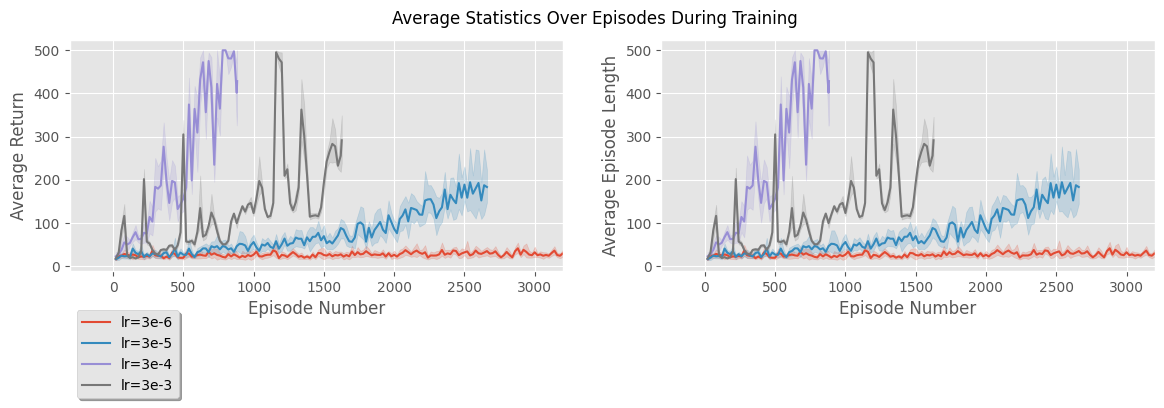

In [7]:
eval_params = edict()  # eval_params - evaluation settings for trained agent

eval_params.run_name00 = "CartPole-v1__REINFORCE__1__250603_173851"
eval_params.exp_type00 = "lr_reinforce"

eval_params.run_name01 = "CartPole-v1__REINFORCE__1__250603_173933"
eval_params.exp_type01 = "lr_reinforce"

eval_params.run_name02 = "CartPole-v1__REINFORCE__1__250603_174000"
eval_params.exp_type02 = "lr_reinforce"

eval_params.run_name03 = "CartPole-v1__REINFORCE__1__250603_174035"
eval_params.exp_type03 = "lr_reinforce"

# eval_params.run_name00 = exp.run_name
# eval_params.exp_type00 = exp.exp_type

agent_labels = ["lr=3e-6", "lr=3e-5", "lr=3e-4", "lr=3e-3"]

episode_axis_limit = 3200

hf.plotter_agents_training_stats(eval_params, agent_labels, episode_axis_limit, plot_returns=True, plot_episode_len=True)

## TensorBoard Inline

In [8]:
# %load_ext tensorboard
# %tensorboard --logdir logs --host localhost